In [1]:
!pip install -q torch pandas numpy scikit-learn matplotlib

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

drive.mount('/content/drive')

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
class BasicLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=1):
        super(BasicLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # last_time_step = lstm_out[:, -1, :]
        # output = self.fc(last_time_step)
        pooled = torch.mean(lstm_out, dim=1)
        output = self.fc(pooled)
        return output

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x_tensor = torch.FloatTensor(x).to(device)
            output = self(x_tensor)
        return output.cpu().numpy()

In [4]:
def prepare_data(df):
    """Prepare data for LSTM using only essential features"""
    # Convert first column to datetime if needed
    print(df.dtypes)

    if 'Unnamed: 0' in df.columns:
        df.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)

    # Remove duplicated datetime columns (if any)
    df = df.loc[:, ~df.columns.duplicated()]


    if df['datetime'].dtype != 'datetime64[ns]':
        df['datetime'] = pd.to_datetime(df['datetime'])

    # Create cyclical time features (since hour and day_of_week are already in the data)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

    # Ensure data is sorted by datetime
    df = df.sort_values('datetime')

    return df

In [5]:
def create_sequences(data, target_col, seq_length=24, include_target=True):
    """Create sequences with option to include target as a feature"""
    # Basic features
    features = data[['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']].values

    # If requested, add the target value itself as a feature
    if include_target:
        # Create lag features of the target
        all_features = []
        for i in range(len(data) - seq_length):
            # Get the features for this sequence
            feat_seq = features[i:i+seq_length]

            # Add the target values from previous timesteps as features
            target_lags = data[target_col].values[i:i+seq_length].reshape(-1, 1)

            # Combine features and target lags
            combined = np.concatenate((feat_seq, target_lags), axis=1)
            all_features.append(combined)

        X = np.array(all_features)
    else:
        # Just use the basic features
        X = []
        for i in range(len(data) - seq_length):
            X.append(features[i:i+seq_length])
        X = np.array(X)

    # Target values
    y = []
    for i in range(len(data) - seq_length):
        y.append(data[target_col].values[i+seq_length])
    y = np.array(y)

    return X, y

In [6]:
def train_model(X_train, y_train, input_size, epochs=50, hidden_size=64, lr=0.001, batch_size=32):
    """Train the LSTM model with batching for better stability"""
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)

    # Create TensorDataset and DataLoader for batching
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Create model
    model = BasicLSTM(input_size, hidden_size).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * len(X_batch)

        # Average loss for the epoch
        avg_loss = epoch_loss / len(X_train)
        losses.append(avg_loss)

        # Print progress
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')

    return model, losses


In [7]:
def evaluate_model(model, X_test, y_test, scaler=None):
    """Evaluate model on test data"""
    # Make predictions
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        predictions = model(X_test_tensor).cpu().numpy()

    # Inverse transform if scaled
    if scaler:
        predictions = scaler.inverse_transform(predictions)
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)


    print("\nTest Metrics:")


    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"RMSE: {rmse:.4f}")

    return predictions, y_test, {'rmse': rmse, 'mae': mae, }


In [8]:
def plot_results(losses, y_test, predictions, dates=None):
    """Plot training loss and predictions"""
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title('FaaS Function Request Prediction')
    plt.xlabel('Time')
    plt.ylabel('Number of Requests')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Create and plot error distribution
    error = y_test - predictions
    plt.figure(figsize=(10, 6))
    plt.hist(error, bins=30)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


In [9]:
def main():

    filename = file_path = "/content/drive/MyDrive/Colab Notebooks/model_dataset_with_datetime.csv"
    df = pd.read_csv(filename)


    print(f"Data shape: {df.shape}")
    print(df.head())

    # Data preparation
    df = prepare_data(df)

    # Scale target values
    scaler = MinMaxScaler()
    df['target_scaled'] = scaler.fit_transform(df[['target']])

    # Create sequences
    seq_length = 24  # Use last 24 hours to predict next hour
    X, y = create_sequences(df, 'target_scaled', seq_length, include_target=True)

    # Split data - train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")

    # Train model
    input_size = X.shape[2]  # Number of features
    hidden_size = 128  # Larger hidden size
    lr = 0.001  # Learning rate
    epochs = 50  # Moderate number of epochs

    model, losses = train_model(
        X_train, y_train,
        input_size=input_size,
        hidden_size=hidden_size,
        lr=lr,
        epochs=epochs
    )

    # Evaluate model
    predictions, y_test_unscaled, metrics = evaluate_model(model, X_test, y_test, scaler)

    # Extract dates for test set if possible
    test_dates = None
    if len(df) > len(y_test) + seq_length:
        # Get the corresponding dates
        test_start_idx = len(df) - len(y_test) - seq_length
        test_end_idx = len(df) - seq_length
        test_dates = df['datetime'].iloc[test_start_idx+seq_length:test_end_idx+seq_length].values

    # Plot results
    plot_results(losses, y_test_unscaled, predictions, test_dates)


    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'input_size': input_size,
        'hidden_size': hidden_size,
        'seq_length': seq_length
    }, 'minimal_lstm_model.pt')

    # Save scaler
    with open('minmax_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    print("\nMinimal model and scaler saved and ready for download")


    # Save results
    save_path = "/content/drive/MyDrive/Colab Notebooks/results/LSTM_test_results.csv"
    predictions_df = pd.DataFrame({'Predicted': predictions.flatten()})
    predictions_df.to_csv(save_path, index=False)

    actual_df = pd.DataFrame({'Actual': y_test_unscaled.flatten()})
    actual_df.to_csv("/content/drive/MyDrive/Colab Notebooks/results/actual_test_results.csv", index=False)


    # Get synthetic dataset
    df_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/synthetic_dataset.csv')
    print(df_csv.dtypes)

    # Prepare dataset
    df_prepared = prepare_data(df_csv)

    # Scale target values
    scaler = MinMaxScaler()
    df_prepared['target_scaled'] = scaler.fit_transform(df_prepared[['target']])

    X_full, y_full = create_sequences(df_prepared, target_col='target_scaled', seq_length=24,include_target=True)

    # Convert to tensor
    X_tensor = torch.tensor(X_full, dtype=torch.float32)
    y_tensor = torch.tensor(y_full, dtype=torch.float32)

    # Use a DataLoader for batch inference
    full_dataset = TensorDataset(X_tensor, y_tensor)
    full_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)

    # Run inference
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for X_batch, y_batch in full_loader:
            X_batch = X_batch.to(device)
            output = model(X_batch).squeeze().cpu().numpy()
            predictions.extend(output)
            actuals.extend(y_batch.numpy())


    # Reshape and inverse scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()


    plt.figure(figsize=(12, 6))
    plt.plot(actuals, label="Actual")
    plt.plot(predictions, label="Predicted")
    plt.title("Predictions on Full Synthetic Dataset")
    plt.xlabel("Time Step")
    plt.ylabel("Number of requests")
    plt.legend()
    plt.grid(True)
    plt.show()

    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions)
    rmse = np.sqrt(mse)

    print("\nTest Metrics:")


    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}")
    print(f"RMSE: {rmse:.4f}")


    df_actuals = pd.DataFrame({"Actual": actuals})
    df_actuals.to_csv("/content/drive/MyDrive/Colab Notebooks/results/actual_synthetic_results.csv", index=False)

    df_results = pd.DataFrame({"Predicted": predictions})
    df_results.to_csv("/content/drive/MyDrive/Colab Notebooks/results/LSTM_synthetic_results.csv", index=False)


Data shape: (2136, 4)
            Unnamed: 0        target  hour  day_of_week
0  2025-02-22 00:00:00  22194.583333     0            5
1  2025-02-22 01:00:00  20487.250000     1            5
2  2025-02-22 02:00:00  20038.716667     2            5
3  2025-02-22 03:00:00  21519.316667     3            5
4  2025-02-22 04:00:00  18344.950000     4            5
Unnamed: 0      object
target         float64
hour             int64
day_of_week      int64
dtype: object
Training set: (1689, 24, 5)
Test set: (423, 24, 5)
Epoch [10/50], Loss: 0.008198
Epoch [20/50], Loss: 0.007088
Epoch [30/50], Loss: 0.005652
Epoch [40/50], Loss: 0.004659
Epoch [50/50], Loss: 0.003687

Test Metrics:
MAE: 3454.0128
MAPE: 0.1358
RMSE: 5612.7953


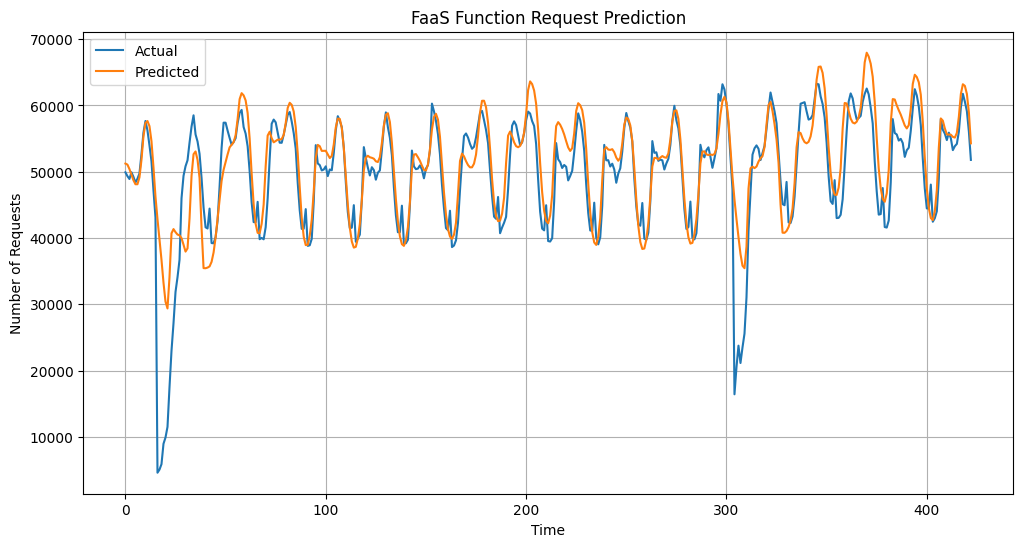

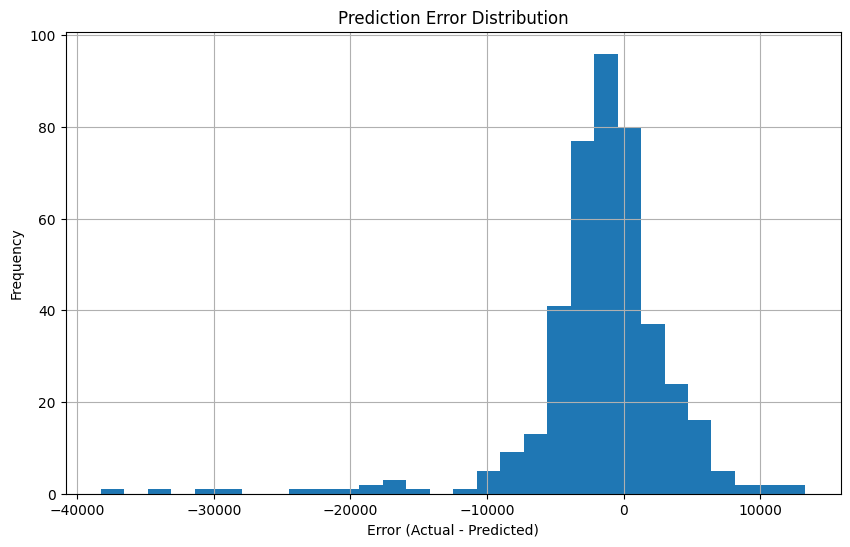


Minimal model and scaler saved and ready for download
datetime       object
target          int64
hour            int64
day_of_week     int64
dtype: object
datetime       object
target          int64
hour            int64
day_of_week     int64
dtype: object


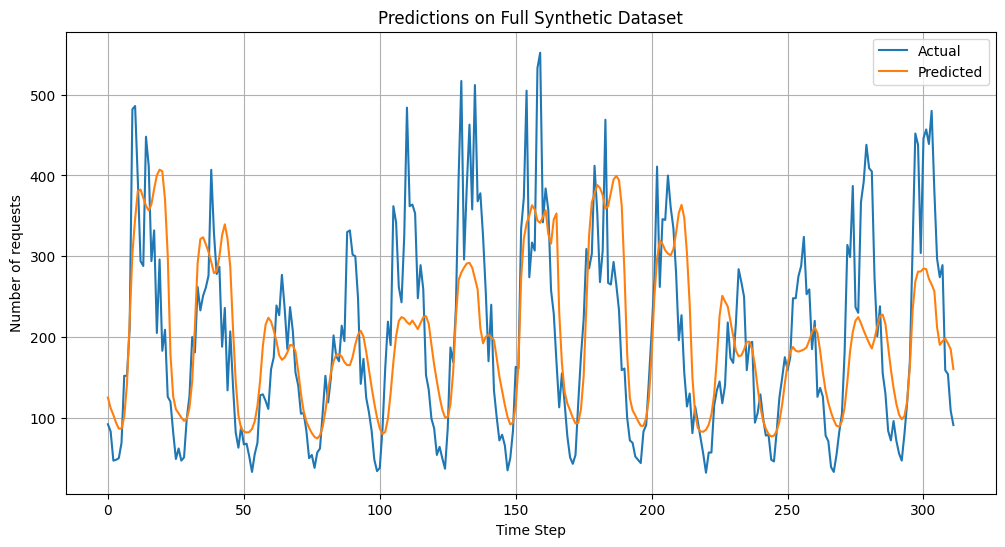


Test Metrics:
MAE: 68.7587
MAPE: 0.44
RMSE: 88.4557


In [10]:
# Run the main function
if __name__ == "__main__":
    main()